In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation
from matplotlib.colors import hsv_to_rgb
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import AxesGrid

In [3]:
folder = 'E:/4D-STEM/Shoucong/Leyi Sample/20211013/remos2_testwithGatan_2/20211013 223804_GB3/'
# path to the file

path = folder+ 'RM.mib'

# bitdepth - this will depend on dynamic range used by MerlinEM detector
bit_depth = np.uint8

# size of the MerlinEM frame
merlin_size = (256,256)

# size of the 4D-STEM scan
scan_size = (256,256)

# endian swap - depends on architecture of the pc
# if in doubt check if counts are devisible by 256 in the final figure
endian_swap = True

# define numpy type for MerlinEM frame, each frame has 384 bytes header after that 256x256 pixel data
merlin_frame_dtype = np.dtype([('header', np.uint8, 384), ('data', bit_depth, merlin_size)])

# map the file to memory
data = np.memmap(path, merlin_frame_dtype, shape=scan_size, mode='r')

# remove header data
data_header_free = data['data']

# swap endian if architecture change
if endian_swap:
    data_header_free = data_header_free.byteswap()

In [4]:
shapes=np.shape(data_header_free)
dat4d = np.reshape(data_header_free, (shapes[0]*shapes[1],shapes[2], shapes[3]))
dat4d= np.reshape(dat4d, (256,256,256,256))

<ipython-input-5-c50741c26237>:11: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
C:\Users\ningustc\anaconda3\lib\site-packages\mpl_toolkits\axes_grid1\axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


Text(0.5, 1.0, 'position averaged CBED')

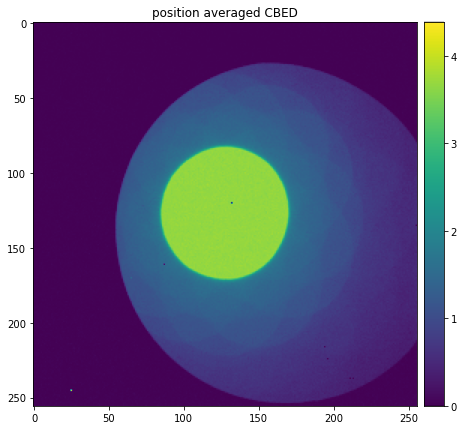

In [5]:
pacbed = np.average(dat4d, axis=(0,1))
fig =plt.figure(1, figsize=(25, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.log10(pacbed*1000+1), cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")

<ipython-input-6-8a60b7ec260e>:17: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-6-8a60b7ec260e>:22: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[2].colorbar(im)


Text(0.5, 1.0, 'Masked PACBED')

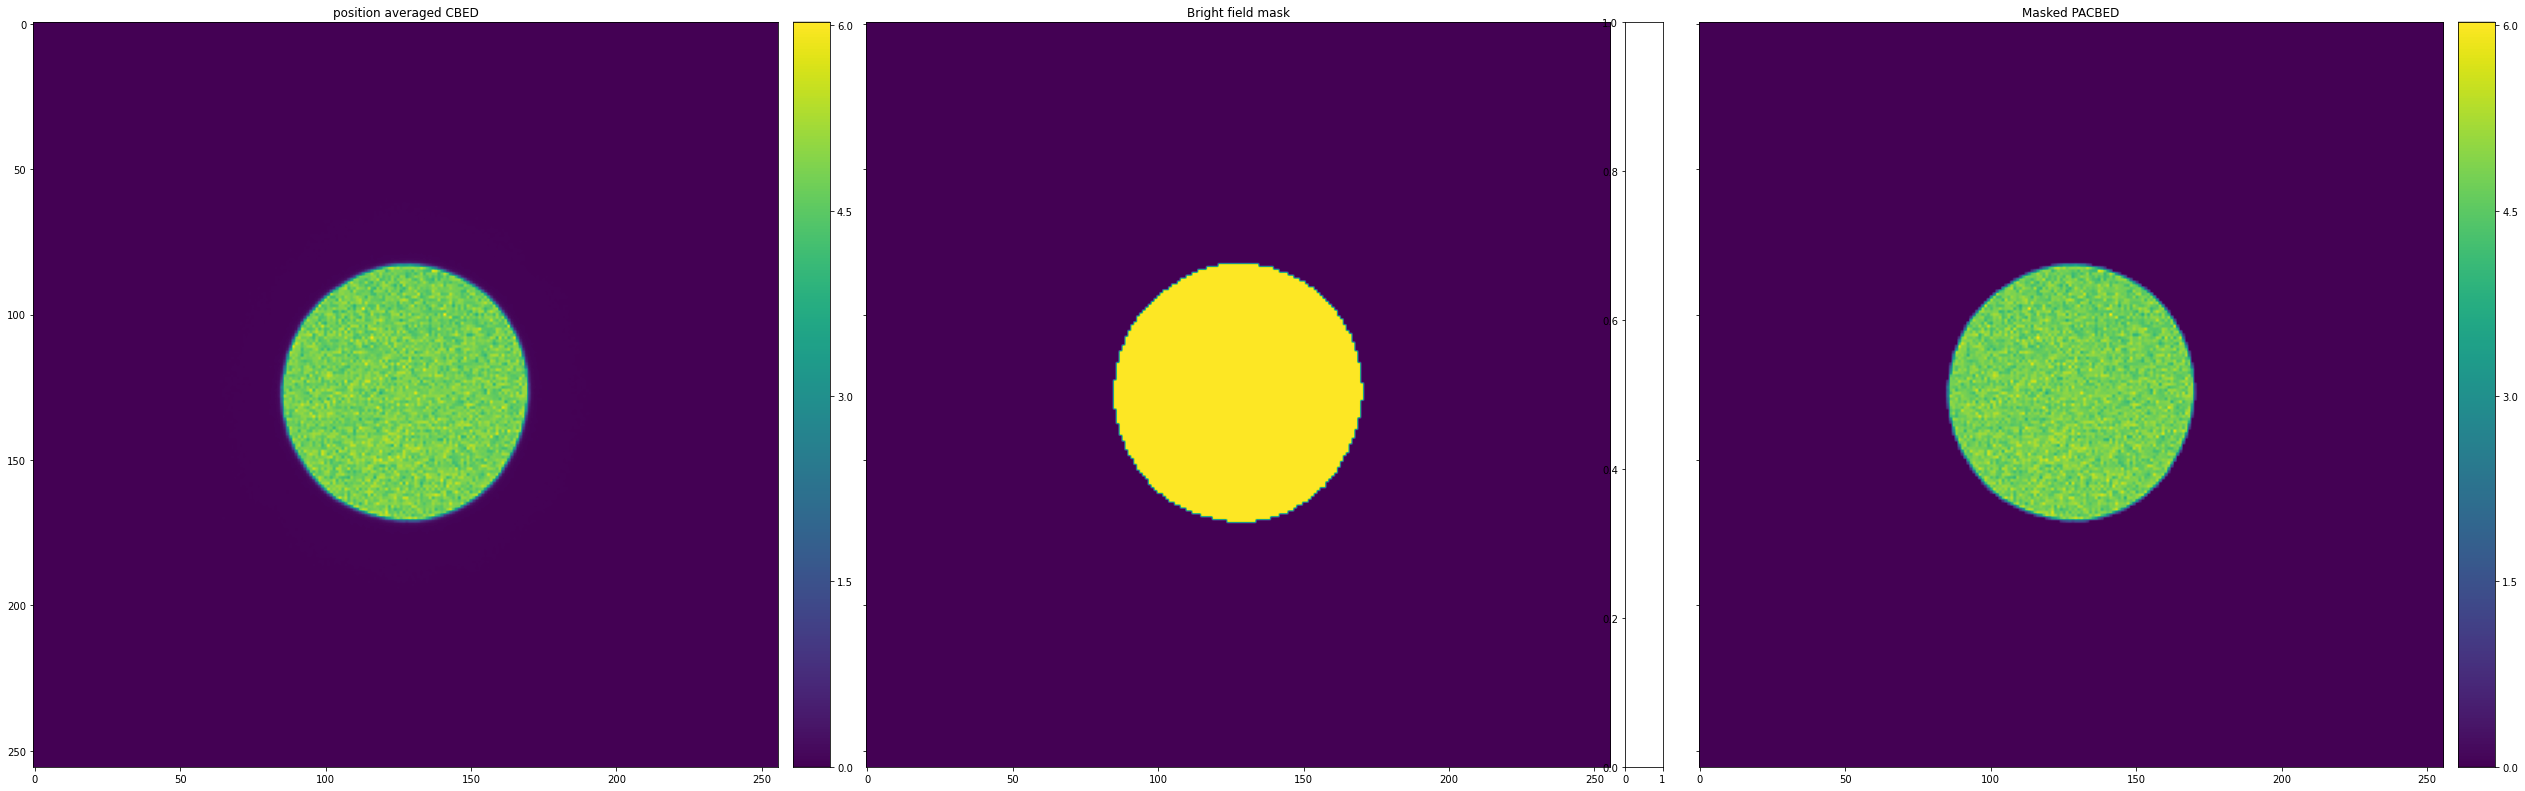

In [6]:
pacbed[120, 132] = pacbed[120, 131]
#pacbed[161, 87] = pacbed[120, 131]
pacbed[245, 25] = 0
thresh = np.average(pacbed)*2.0
BFdisk = pacbed > thresh
mpacbed = pacbed * BFdisk
#get the mask of aperture via threshold values.
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(BFdisk, cmap=plt.cm.viridis)
grid[1].set_title("Bright field mask")
im=grid[2].imshow(mpacbed, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Masked PACBED")

In [7]:
#compute the center of aperture according to determined mask image. 
X, Y = np.meshgrid(np.arange(0, pacbed.shape[1]), np.arange(0, pacbed.shape[0]))
x_center, y_center =np.average(mpacbed * X), np.average(mpacbed * Y)
x_center/=np.average(mpacbed)
y_center/=np.average(mpacbed)
#get the edge of bright field apertuer and fit the radius in pixels. 
grad=np.sqrt(np.sum(np.square(np.abs(np.gradient(pacbed))), axis =0))
edge = grad > np.max(grad)*0.5
radius = np.average(np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)[edge])
#get the half of the aperture to compute ABF
InnerBFdisk = (np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2))<(radius/2)
BFImage=[]
InnerBFImage=[]
for ycan in range(np.shape(dat4d)[0]):
    for xcan in range(np.shape(dat4d)[1]):
        BFImage.append(np.sum(dat4d[ycan,xcan,:,:]*BFdisk))
        InnerBFImage.append(np.sum(dat4d[ycan,xcan,:,:]*InnerBFdisk))
BFImage = np.reshape(np.asarray(BFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
InnerBFImage = np.reshape(np.asarray(InnerBFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
ADFImage = np.sum(dat4d, axis=(2,3))-BFImage
ABFImage = BFImage - InnerBFImage

<ipython-input-12-665a5cd5c051>:12: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-12-665a5cd5c051>:15: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[1].colorbar(im)
<ipython-input-12-665a5cd5c051>:18: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar impl

Text(0.5, 1.0, 'Annular Dark Field Image')

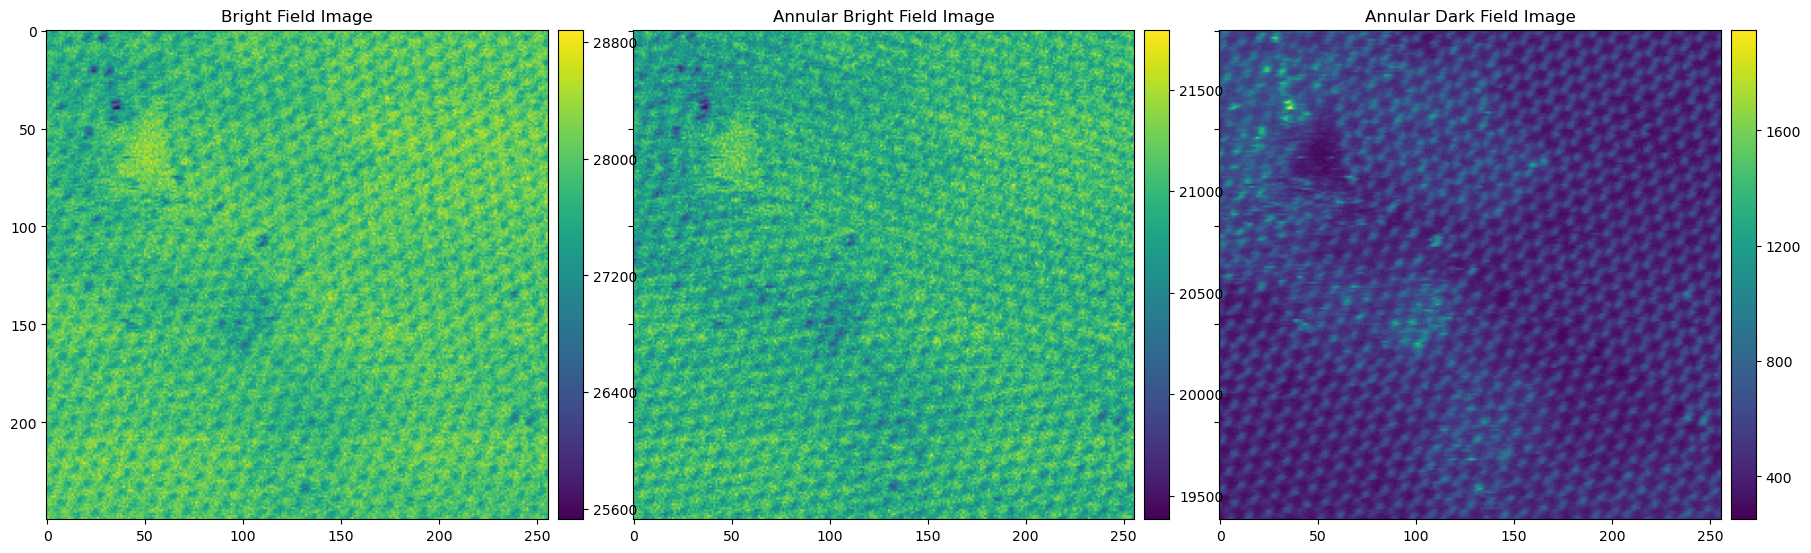

In [12]:
plt.rcParams['figure.dpi']=100
#get the mask of aperture via threshold values.
fig =plt.figure(1, figsize=(75, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(BFImage[6:256], cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Bright Field Image")
im=grid[1].imshow(ABFImage[6:256], cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Annular Bright Field Image")
im=grid[2].imshow(ADFImage[6:256], cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Annular Dark Field Image")

In [13]:
np.save(folder+"data.npy", dat4d[6:256])